## 1> Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.python.keras import regularizers
from tensorflow.keras import Model
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2> Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#Had problem using "gdown", so ran the below code.
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
# https://drive.google.com/file/d/1znyJSkgkZQsNY4H5wOh3SeGKIdB4YxiH/view?usp=share_link
!gdown 1znyJSkgkZQsNY4H5wOh3SeGKIdB4YxiH

Downloading...
From: https://drive.google.com/uc?id=1znyJSkgkZQsNY4H5wOh3SeGKIdB4YxiH
To: /content/archive.zip
100% 390M/390M [00:06<00:00, 60.3MB/s]


In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner37_964.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner47_973.jpg  
  inflating: 105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner48_974.jpg  
  inflating: 105_classes_pins_dataset

## 3> Visualizing the dataset

In [ ]:
class_dirs = os.listdir("105_classes_pins_dataset/") # list all directories inside "product_detection_from_packshots" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'105_classes_pins_dataset/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

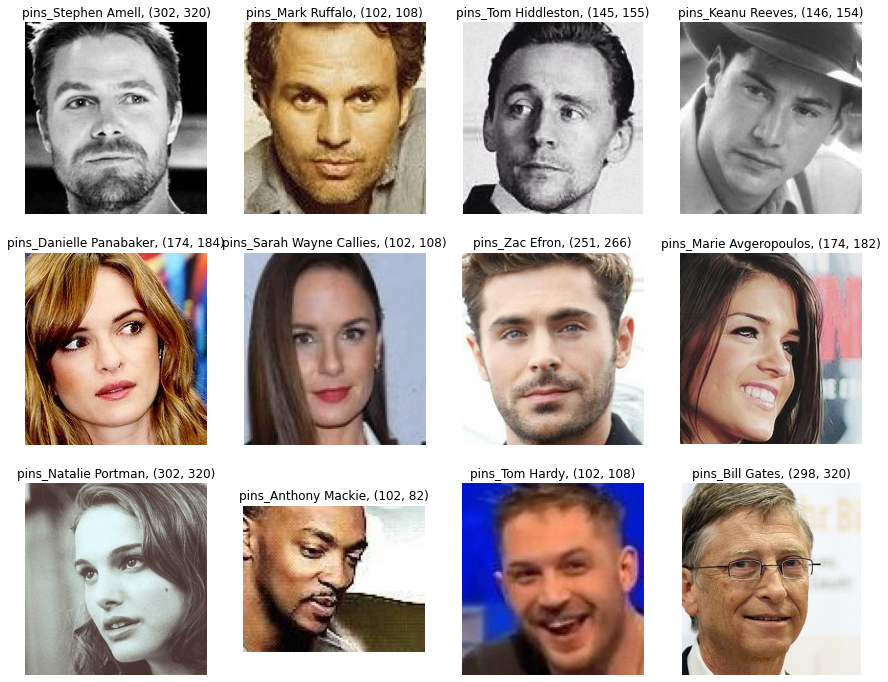

In [ ]:
## Viz Random Sample from each class

plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    j = i+1   
    # create a subplot axis
    if j<13:
        ax = plt.subplot(3, 4, j)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
                         class  count
0          pins_Stephen Amell    159
1           pins_Mark Ruffalo    178
2         pins_Tom Hiddleston    181
3           pins_Keanu Reeves    160
4     pins_Danielle Panabaker    181
..                        ...    ...
100     pins_Katharine Mcphee    177
101  pins_alycia dabnem carey    211
102         pins_Logan Lerman    212
103      pins_Maisie Williams    193
104           pins_Bill Gates    122

[105 rows x 2 columns]


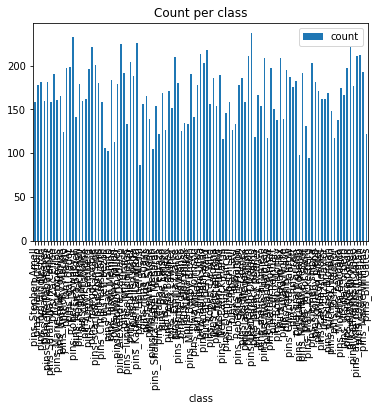

In [ ]:
## Let's now Plot the Data Distribution across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Count per class") 

## 4> Data Preprocessing: Resizing, Standardization and Data Splitting-Train, CV & Test

In [ ]:
def preprocess(train_data, test_data, target_height=128, target_width=128):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = tf.keras.Sequential(
        name="data_preprocess",
        layers=[
            tf.keras.layers.Resizing(target_height, target_width),
            tf.keras.layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, test_ds

## 5> Try 1: Using Pretrained Yoloface Git Repo got Face Detection 

In [ ]:
!git clone https://github.com/sthanhng/yoloface

Cloning into 'yoloface'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 1.40 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
!pip install -r /content/yoloface/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp -r "/content/gdrive/MyDrive/face_recognition/pretrained_yolov3/yolov3-wider_16000.weights" /content/yoloface/model-weights

In [ ]:
!cd /content/yoloface && python yoloface.py --image "/content/yoloface/samples/meeting_11_304.jpg"

----- info -----
[i] The config file:  ./cfg/yolov3-face.cfg
[i] The weights of model file:  ./model-weights/yolov3-wider_16000.weights
[i] Path to image file:  /content/yoloface/samples/meeting_11_304.jpg
[i] Path to video file:  
###########################################################

==> Creating the outputs/ directory...
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.8/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



## 6> Try 2: Using Pretrained YoloV5 Git Repo got Face Detection

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 15002 (delta 1), reused 3 (delta 1), pack-reused 14995
Receiving objects: 100% (15002/15002), 14.09 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (10281/10281), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp -r "/content/gdrive/MyDrive/face_recognition/pretrained_yolov5/face_detection_yolov5s.pt" /content/yolov5/models

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/models/face_detection_yolov5s.pt --source "/content/105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima101_3.jpg"

detect: weights=['/content/yolov5/models/face_detection_yolov5s.pt'], source=/content/105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima101_3.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
newYOLOv5s summary: 224 layers, 7053910 parameters, 0 gradients
image 1/1 /content/105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima101_3.jpg: 640x608 1 Face, 523.4ms
Speed: 3.7ms pre-process, 523.4ms inference, 15.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


## 7> Try 3: Using Mediapipe Library for Face Detection(Got more Accuracy)

In [ ]:
!pip install mediapipe
!pip install face-detector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 5.4 MB/s eta 0:0

In [ ]:
import cv2
import mediapipe as mp

In [ ]:
def face_detect(IMAGE_FILES):
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        for idx, file in enumerate(IMAGE_FILES):
            image = cv2.imread(file)
            image = cv2.resize(image, (256, 256)) 
            # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # Draw face detections of each face.
            if not results.detections:
                return 'Not detected'
            annotated_image = image.copy()
            for detection in results.detections:
                #print('Nose tip:')
                #print(mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
                #print(detection.location_data.relative_bounding_box)
                mp_drawing.draw_detection(annotated_image, detection)
            cv2.imwrite('/content/out/annotated_image' + str(idx) + '.jpg', annotated_image)
            return (detection.location_data.relative_bounding_box.xmin, detection.location_data.relative_bounding_box.ymin, detection.location_data.relative_bounding_box.width, detection.location_data.relative_bounding_box.height)

In [ ]:
IMAGE_FILES = ["/content/105_classes_pins_dataset/pins_Millie Bobby Brown/Millie Bobby Brown155_3808.jpg"]
face_detect(IMAGE_FILES)

(0.02623423933982849,
 0.27736324071884155,
 0.3644355833530426,
 0.36432212591171265)

Observation: Got highest accuracy with Mediapipe, so selecting Mediapipe function for future use.<br>
Why did I use Yolo and Mediapipe only?<br>
Because these 2 are light and fast models

## 8> Creating a function to extract feature embedding from an Image using Resnet50 - Method 1

In [ ]:
import numpy as np
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import Image

# Load the ResNet50 model
model = ResNet50(weights='imagenet')

# Get the output of the final global average pooling layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

def extract_features(image_paths, bbox):
    # Open the image
    image = Image.open(image_paths)
    # Convert the image to a numpy array
    image_array = np.array(image)
    print(image_array)
    # Crop the image to the bounding box
    x, y, w, h = bbox
    crop = image.crop((x, y, x+w, y+h))

    # Preprocess the cropped image for ResNet50
    crop = preprocess_input(crop)

    # Get the features for the cropped image
    features = feature_extractor.predict(np.expand_dims(crop, axis=0))
    
    return features.flatten()

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
image_path = ["/content/yolov5/runs/detect/exp/Adriana Lima101_3.jpg"]
bbox = face_detect(image_path)
print(bbox)
extract_features(image_path[0], bbox)

(0.08782808482646942, 0.16264823079109192, 0.7427631616592407, 0.742740273475647)
[[[  9   9   9]
  [  3   3   3]
  [  6   6   6]
  ...
  [ 59  58  64]
  [ 60  59  65]
  [ 62  61  67]]

 [[  9   9   9]
  [  5   5   5]
  [  9   9   9]
  ...
  [ 62  61  67]
  [ 63  62  68]
  [ 64  63  69]]

 [[ 11  11  11]
  [  6   6   6]
  [  9   9   9]
  ...
  [ 64  63  69]
  [ 66  65  71]
  [ 66  65  71]]

 ...

 [[128 145 161]
  [127 144 160]
  [132 151 166]
  ...
  [ 52  55  64]
  [ 53  55  67]
  [ 54  58  69]]

 [[126 143 159]
  [126 143 159]
  [131 148 166]
  ...
  [ 52  56  67]
  [ 53  57  68]
  [ 54  58  69]]

 [[129 146 162]
  [128 145 163]
  [131 148 166]
  ...
  [ 51  55  66]
  [ 51  55  66]
  [ 53  57  68]]]


TypeError: ignored

## 9> Creating a function to extract feature embedding from an Image using Resnet50 - Method 2

In [ ]:
import torch
from torchvision import models
from torchvision import transforms
from PIL import Image

# Load a pre-trained model (e.g. ResNet-50)
model = models.resnet50(pretrained=True)
# Remove the last fully connected layer to get the feature embeddings
model = torch.nn.Sequential(*list(model.children())[:-1])
# Set the model to eval mode
model.eval()

# Define the image pre-processing steps
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_embeddings(image, bounding_box):
    try:
        image = Image.open(image)
        # Crop the image to the bounding box
        x, y, w, h = bounding_box
        crop = image.crop((x, y, x+w, y+h))
        # Pre-process the image
        tensor = transform(crop).unsqueeze(0)
        # Extract the feature embeddings
        with torch.no_grad():
            embeddings = model(tensor)
        return embeddings
    except ZeroDivisionError:
        return 'Error'

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
image_paths = [["/content/105_classes_pins_dataset/pins_Millie Bobby Brown/Millie Bobby Brown155_3808.jpg"]]
bounding_box = face_detect(image_paths[0])
print(len(bounding_box))
extract_embeddings(image_paths[0][0], bounding_box)

4


'Error'

## 10> Creating a function to return 3 lists - Class of the image, Path of the image & Feature Embedding of the Image

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
from pandas.core.tools.datetimes import Tuple
from torch._C import NoneType
# Function to Extract features from the images
def image_feature(path):
    features = [];
    img_name = [];
    path_names = [];
    #path = "/content/105_classes_pins_dataset"
    for name_folder in os.listdir(path):
        print(name_folder)
        file_path = path+'/'+name_folder+'/'
        for file in os.listdir(file_path):
            image_path = file_path+file
            img=image.load_img(image_path,target_size=(224,224))
            bounding_box = face_detect([image_path])
            if bounding_box!='Not detected':
                #print(bounding_box)
                emb = extract_embeddings(image_path, bounding_box)
                if type(emb) is not str:
                    feat = emb.flatten()
                    print(image_path)
                    print(feat)
                    print(feat.shape)
                    features.append(np.array(feat))
                    img_name.append(name_folder)
                    path_names.append(image_path)
    return path_names, img_name, features

# Function to Extract features from the images
# def extract_image_feature(path):
#     features = [];
#     img_name = [];
#     path = "/content/105_classes_pins_dataset"
#     for name_folder in os.listdir(path):
#         print(name_folder)
#         file_path = path+'/'+name_folder+'/'
#         for file in os.listdir(file_path):
#             image_path = file_path+file
#             img=image.load_img(image_path,target_size=(256,256))
#             x = img_to_array(img)
#             x=np.expand_dims(x,axis=0)
#             x=preprocess_input(x)
#             feat=model.predict(x)
#             feat=feat.flatten()
#             print(feat)
#             print(feat.shape)
#             print(type(feat))
#             features.append(feat)
#             img_name.append(i)
#         return features,img_name

In [ ]:
path = "/content/105_classes_pins_dataset"
img_path, img_name, img_features=image_feature(path)

Streaming output truncated to the last 5000 lines.
tensor([0.6316, 0.0073, 0.0298,  ..., 0.2363, 0.0000, 0.0101])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor20_2195.jpg
tensor([0.1656, 0.0160, 0.0215,  ..., 0.0628, 0.0078, 0.0300])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor97_2266.jpg
tensor([0.3800, 0.0014, 0.0308,  ..., 0.0983, 0.0018, 0.0145])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor104_2151.jpg
tensor([0.1102, 0.0468, 0.0476,  ..., 0.0359, 0.0099, 0.0140])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor9_2265.jpg
tensor([0.3847, 0.0007, 0.0284,  ..., 0.0769, 0.0026, 0.0123])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor6_2243.jpg
tensor([0.0827, 0.0426, 0.0203,  ..., 0.0478, 0.0084, 0.0078])
torch.Size([2048])
/content/105_classes_pins_dataset/pins_Josh Radnor/Josh Radnor121_2160.jpg
tensor([0.192

In [ ]:
len(img_features)

14905

In [ ]:
img_features

[array([0.00862767, 0.00270946, 0.00215831, ..., 0.00763008, 0.        ,
        0.02522242], dtype=float32),
 array([0.28434315, 0.00436662, 0.02529678, ..., 0.07011124, 0.00284264,
        0.01600064], dtype=float32),
 array([0.18176207, 0.03104991, 0.05326465, ..., 0.04599416, 0.03177362,
        0.02245984], dtype=float32),
 array([0.19817488, 0.00478121, 0.03042447, ..., 0.05596035, 0.00666394,
        0.03321402], dtype=float32),
 array([0.05077631, 0.02439063, 0.03032738, ..., 0.0324706 , 0.        ,
        0.02407975], dtype=float32),
 array([0.02692676, 0.01329832, 0.01298464, ..., 0.02653767, 0.        ,
        0.00706695], dtype=float32),
 array([0.17082982, 0.00488218, 0.02204052, ..., 0.05360089, 0.00251683,
        0.01858237], dtype=float32),
 array([0.2858545 , 0.04285748, 0.0739925 , ..., 0.0491086 , 0.01331195,
        0.01053679], dtype=float32),
 array([0.01190558, 0.00306235, 0.01405573, ..., 0.02287748, 0.        ,
        0.01796724], dtype=float32),
 array([0.

## 11> Creating the dataframe for the data extracted above

In [ ]:
df = pd.DataFrame(list(zip(img_path, img_name, img_features)), columns =['Path', 'Celebrity', 'Feature_Embedding'])
df

,Path,Celebrity,Feature_Embedding
0,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.008627666, 0.0027094565, 0.0021583098, 0.0,..."
1,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.28434315, 0.0043666176, 0.025296781, 0.0205..."
2,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.18176207, 0.031049905, 0.053264648, 0.00438..."
3,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.19817488, 0.0047812117, 0.030424468, 0.0013..."
4,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.05077631, 0.024390634, 0.030327378, 0.0, 0...."
...,...,...,...
14900,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.085417405, 0.036304835, 0.04836345, 0.0, 0...."
14901,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.03472591, 0.06498817, 0.05513926, 0.0, 0.0,..."
14902,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.03400515, 0.01037668, 0.01462741, 0.0, 0.05..."
14903,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.050726842, 0.022502115, 0.038797524, 0.0, 0..."


In [ ]:
# saving the dataframe
df.to_csv('/content/gdrive/MyDrive/face_recognition/features_file.csv')

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/face_recognition/features_file.csv")
df

,Unnamed: 0,Path,Celebrity,Feature_Embedding
0,0,/content/105_classes_pins_dataset/pins_Ursula ...,pins_Ursula Corbero,[0.0965476 0.05815694 0.07230305 ... 0.029021...
1,1,/content/105_classes_pins_dataset/pins_Ursula ...,pins_Ursula Corbero,[0.04704474 0.01476635 0.01935564 ... 0.057110...
2,2,/content/105_classes_pins_dataset/pins_Ursula ...,pins_Ursula Corbero,[0.04495584 0.04610025 0.0486451 ... 0.041605...
3,3,/content/105_classes_pins_dataset/pins_Ursula ...,pins_Ursula Corbero,[0.28075552 0.01297965 0.02134675 ... 0.066478...
4,4,/content/105_classes_pins_dataset/pins_Ursula ...,pins_Ursula Corbero,[0.3127617 0.00423972 0.02053874 ... 0.057715...
...,...,...,...,...
14900,14900,/content/105_classes_pins_dataset/pins_ellen p...,pins_ellen page,[0.308099 0.08553495 0.02109358 ... 0.037716...
14901,14901,/content/105_classes_pins_dataset/pins_ellen p...,pins_ellen page,[0.08830713 0.0363961 0.02497083 ... 0.033533...
14902,14902,/content/105_classes_pins_dataset/pins_ellen p...,pins_ellen page,[0.19107963 0.06606004 0.02239609 ... 0.027153...
14903,14903,/content/105_classes_pins_dataset/pins_ellen p...,pins_ellen page,[0.13175966 0.02733131 0.01849141 ... 0.086353...


## 12> Storing all the Feature Embeddings extracted to a pickle file

In [ ]:
# Using pickle to store the feature embeddings
import pickle as pkl

# Store the feature embeddings in pickle format
with open('/content/gdrive/MyDrive/face_recognition/feature_embeddings.pickle', 'wb') as handle:
    pickle.dump(img_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load saved model
with open('/content/gdrive/MyDrive/face_recognition/feature_embeddings.pickle' , 'rb') as f:
    all_feature = pickle.load(f)

## Generating a KNN model to suggest which celebrity the query image belongs to

In [ ]:
# Importing necessary dependencies
from sklearn.neighbors import NearestNeighbors

# Define a function to plot the images
def plot_images(filenames, distances, celebrity_name):
    # Create an empty list
    images = []
    # Loop through the filenames
    for filename in filenames:
        # Read the image files
        images.append(mpimg.imread(filename))
    # Create a Plot for displaying images
    plt.figure(figsize=(20, 10))

    

    # Define the no. of images
    columns = 5
    # Loop through the images
    for i, image in enumerate(images):
        # Create a subplot for the images
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        # Set the axis off
        ax.axis('off')
        # Set the name of the image
        ax.set_title(titles[i] + "\nPrice : {} ₹".format(prices[i]), y=-0.05,pad=-14)
        # Display the image inside the subplot
        plt.imshow(image)
        


# Define a function to display similar images
def find_similar_images(img_path, old_features_path, model, sex = 1) :

  if not os.path.exists(img_path) :
    return None

  # Finding the category of the input image using its path
  category = img_path.split('/')[-1].split('.')[0].lower()

  # Defining the sex attribute for the input image
  if category == 'handbag' :
    sex = "Women"

  else:
    if sex == 1:
      sex = 'Men'
    else:
      sex = 'Women'

  # Extract features from the input image
  new_embedding = extract_features(img_path, model)

  # Define a new list
  new_embedding_arr = []

  # Loop through the emebddings
  for i in range(len(new_embedding)) : 
    # Convert the numpy array to a Python list iteratively
    new_embedding_arr.append(new_embedding[i])

  # Make an object of the class StandardScaler()
  scaler = StandardScaler()
  # Scale the extracted features
  new_feature_scaled = scaler.fit_transform(new_embedding.reshape(-1,1))

  # Remove single-dimensional entries from the shape of an array.
  new_feature_scaled = np.array(new_feature_scaled).squeeze()

  # Load the old embeddings from the pre-saved pickle file
  old_features = np.load(old_features_path, allow_pickle = True)

  # Define the NearestNeighbors object for implementing the KNN algorithm
  neighbors = NearestNeighbors(n_neighbors=70, algorithm='brute', metric='euclidean').fit(old_features)
  # Fetch the distances and indices of the 30 closest feature vectors
  distances, indices = neighbors.kneighbors([new_feature_scaled])


  # Define an empty list
  filenames, links, prices, titles = [], [], [], []
  # Define the counter( We'll use this counter to save the first 5 similar images)
  count = 0
  
  # Loop through the indices
  for index in indices[0] :
    # Apply the conditions for sex and category
    if (data_json.iloc[index,:]['sex']==sex ) and (data_json.iloc[index,:]['category'] == category) :
      # Define the image path
      img_path = os.path.join(root_dir, data_json.iloc[index,:]['category'], data_json.iloc[index,:]['name']) + '.jpg'
      
      # Check if the path exists
      if os.path.exists(img_path) :
        # Add the image path to the list if it exists
        filenames.append(img_path)

        links.append(data_json.iloc[index,:]['link'])
        titles.append(data_json.iloc[index,:]['title'])
        prices.append(data_json.iloc[index,: ]['price'])
        # Increment the counter
        count += 1

    # Break the loop if the counter reaches 5    
    if count==5 :
      break
  
  # Use the plot_images function to display the similar image
  plot_images(filenames, distances, titles, prices)

## 13> Generating a Kmeans model to suggest which celebrity the query image belongs to

In [ ]:
df[['Celebrity']]

,Celebrity
0,pins_Stephen Amell
1,pins_Stephen Amell
2,pins_Stephen Amell
3,pins_Stephen Amell
4,pins_Stephen Amell
...,...
14900,pins_Bill Gates
14901,pins_Bill Gates
14902,pins_Bill Gates
14903,pins_Bill Gates


In [ ]:
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

    
# Split the features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[['Feature_Embedding','Celebrity']], df[['Celebrity']], test_size=0.2)

print(X_train)

                                       Feature_Embedding  \
10513  [0.046625476, 0.011831243, 0.017747635, 0.0, 0...   
6372   [0.0410022, 0.032246497, 0.02187584, 0.0, 0.0,...   
9549   [0.074959815, 0.011251045, 0.018586414, 0.0050...   
14409  [0.09816631, 0.0, 0.0036848602, 0.0, 0.1996269...   
9187   [0.053657994, 0.007616196, 0.015090561, 0.0, 0...   
...                                                  ...   
682    [0.22869141, 0.013979416, 0.009251567, 0.00133...   
3721   [0.064686984, 0.0, 0.011645839, 0.0, 0.0087243...   
10572  [0.28417838, 0.01998356, 0.04732803, 0.0063427...   
3789   [0.12778257, 0.027336573, 0.05437802, 0.0, 0.0...   
11168  [0.25619513, 0.0, 0.075422645, 0.0010928025, 0...   

                      Celebrity  
10513       pins_Natalie Dormer  
6372     pins_Jennifer Lawrence  
9549           pins_Emma Watson  
14409  pins_alycia dabnem carey  
9187          pins_Selena Gomez  
...                         ...  
682     pins_Danielle Panabaker  
3721   

In [ ]:
print(y_test)

                     Celebrity
11782   pins_Cristiano Ronaldo
4315        pins_Sophie Turner
13966     pins_elizabeth olsen
3456          pins_Jason Momoa
13545     pins_Morena Baccarin
...                        ...
1352       pins_Anthony Mackie
3806   pins_Alexandra Daddario
2820   pins_scarlett johansson
98          pins_Stephen Amell
1082   pins_Marie Avgeropoulos

[2981 rows x 1 columns]


In [ ]:
df

,Path,Celebrity,Feature_Embedding
0,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.008627666, 0.0027094565, 0.0021583098, 0.0,..."
1,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.28434315, 0.0043666176, 0.025296781, 0.0205..."
2,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.18176207, 0.031049905, 0.053264648, 0.00438..."
3,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.19817488, 0.0047812117, 0.030424468, 0.0013..."
4,/content/105_classes_pins_dataset/pins_Stephen...,pins_Stephen Amell,"[0.05077631, 0.024390634, 0.030327378, 0.0, 0...."
...,...,...,...
14900,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.085417405, 0.036304835, 0.04836345, 0.0, 0...."
14901,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.03472591, 0.06498817, 0.05513926, 0.0, 0.0,..."
14902,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.03400515, 0.01037668, 0.01462741, 0.0, 0.05..."
14903,/content/105_classes_pins_dataset/pins_Bill Ga...,pins_Bill Gates,"[0.050726842, 0.022502115, 0.038797524, 0.0, 0..."


In [ ]:
len(X_train["Feature_Embedding"][11499])

2048

In [ ]:
embeddings = pd.DataFrame.from_records(df['Feature_Embedding'].values)
print(embeddings)

           0         1         2         3         4         5         6     \
0      0.008628  0.002709  0.002158  0.000000  0.274539  0.094316  0.103748   
1      0.284343  0.004367  0.025297  0.020502  0.026068  0.126414  0.209892   
2      0.181762  0.031050  0.053265  0.004389  0.000132  0.196040  0.211431   
3      0.198175  0.004781  0.030424  0.001331  0.025152  0.106408  0.298168   
4      0.050776  0.024391  0.030327  0.000000  0.000000  0.016065  0.078773   
...         ...       ...       ...       ...       ...       ...       ...   
14900  0.085417  0.036305  0.048363  0.000000  0.000000  0.021261  0.019919   
14901  0.034726  0.064988  0.055139  0.000000  0.000000  0.014138  0.135214   
14902  0.034005  0.010377  0.014627  0.000000  0.050722  0.047965  0.082525   
14903  0.050727  0.022502  0.038798  0.000000  0.013988  0.039371  0.120639   
14904  0.159180  0.000000  0.053051  0.000000  0.060336  0.085338  0.041134   

           7         8         9     ...      2038 

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Initialize and fit k-means model
kmeans = KMeans(n_clusters=105)
clustering = kmeans.fit(embeddings)

In [ ]:
import pickle

# Save the model to a pickle file
with open('/content/gdrive/MyDrive/face_recognition/kmeans_weights.pkl', 'wb') as f:
    pickle.dump(clustering, f)

In [ ]:
embeddings_test = pd.DataFrame.from_records(X_test['Feature_Embedding'].values)
print(embeddings_test)

# Predict the cluster labels for the test set
y_pred = kmeans.predict(embeddings_test)

# Measure the accuracy of the model
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.2f}')

          0         1         2         3         4         5         6     \
0     0.066413  0.012063  0.013575  0.005281  0.063629  0.124029  0.147364   
1     0.324932  0.100348  0.012819  0.000000  0.052544  0.157087  0.180804   
2     0.471999  0.004216  0.037810  0.066462  0.003596  0.168622  0.248034   
3     0.144437  0.042694  0.050049  0.000000  0.002692  0.038905  0.027055   
4     0.113602  0.000000  0.013445  0.000000  0.018452  0.103642  0.082149   
...        ...       ...       ...       ...       ...       ...       ...   
2976  0.035638  0.018081  0.014520  0.000000  0.000000  0.003673  0.033263   
2977  0.065569  0.001311  0.008491  0.000000  0.000000  0.031109  0.063185   
2978  0.014341  0.000000  0.008889  0.000000  0.148988  0.074441  0.109298   
2979  0.040680  0.000595  0.038617  0.000000  0.003592  0.005460  0.031674   
2980  0.251763  0.022694  0.021867  0.005567  0.042822  0.192067  0.118975   

          7         8         9     ...      2038      2039  20

In [ ]:
y_pred

array([71, 76, 70, ..., 16, 60, 94], dtype=int32)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings_test, y_pred)
print(silhouette)

0.2103681


In [ ]:
# Get the cluster labels for each data point
labels = kmeans.labels_

#Plot the data points, color-coded by cluster label
example = np.concatenate((embeddings.index,labels), axis=0)
print(example)
print(len(example))



[ 0  1  2 ...  7 10  0]
23848


In [ ]:
embeddings.index

RangeIndex(start=0, stop=11924, step=1)

In [ ]:
labels

array([89, 15, 89, ...,  7, 10,  0], dtype=int32)

In [ ]:
len(labels)

11924

In [ ]:
len(embeddings.index)

11924

In [ ]:
exp = pd.DataFrame({'embeddings': embeddings.index, 'celebrity_name': X_train.Celebrity, 'labels': labels})
exp

,embeddings,celebrity_name,labels
7955,0,pins_Madelaine Petsch,89
7761,1,pins_jeff bezos,15
10017,2,pins_Alex Lawther,89
2972,3,pins_Millie Bobby Brown,99
3370,4,pins_Adriana Lima,48
...,...,...,...
14099,11919,pins_Johnny Depp,7
11453,11920,pins_Krysten Ritter,57
12769,11921,pins_Sarah Wayne Callies,7
10548,11922,pins_margot robbie,10


In [ ]:
exp = pd.DataFrame({'embeddings': embeddings_test.index, 'celebrity_name': X_test.Celebrity, 'labels': y_pred})
exp

,embeddings,celebrity_name,labels
4350,0,pins_Anne Hathaway,71
8436,1,pins_Robert Downey Jr,76
13477,2,pins_Wentworth Miller,70
194,3,pins_scarlett johansson,42
12175,4,pins_Elizabeth Lail,89
...,...,...,...
10301,2976,pins_Emilia Clarke,60
14764,2977,pins_ellen page,95
4371,2978,pins_Anne Hathaway,16
1512,2979,pins_Emma Stone,60


## Testing Kmeans with test images

In [ ]:
#https://drive.google.com/file/d/1m1qNm2oHa-mOfLRnQXLhuhNSPAkEUVX9/view?usp=share_link
!gdown 1m1qNm2oHa-mOfLRnQXLhuhNSPAkEUVX9

Downloading...
From: https://drive.google.com/uc?id=1m1qNm2oHa-mOfLRnQXLhuhNSPAkEUVX9
To: /content/yolov5/face_cluster_test.zip
100% 13.7M/13.7M [00:00<00:00, 116MB/s] 


In [ ]:
!unzip face_cluster_test.zip

Archive:  face_cluster_test.zip
   creating: face_cluster_test/faces/
  inflating: face_cluster_test/faces/009c52a5.jpg  
  inflating: face_cluster_test/faces/00c79dfd.jpg  
  inflating: face_cluster_test/faces/019034b8.jpg  
  inflating: face_cluster_test/faces/0208b832.jpg  
  inflating: face_cluster_test/faces/02b80824.jpg  
  inflating: face_cluster_test/faces/054fe83f.jpg  
  inflating: face_cluster_test/faces/056d25fb.jpg  
  inflating: face_cluster_test/faces/05ac715f.jpg  
  inflating: face_cluster_test/faces/070685d0.jpg  
  inflating: face_cluster_test/faces/07f31c16.jpg  
  inflating: face_cluster_test/faces/08b625f6.jpg  
  inflating: face_cluster_test/faces/08b94e4d.jpg  
  inflating: face_cluster_test/faces/08c58659.jpg  
  inflating: face_cluster_test/faces/08d249f3.jpg  
  inflating: face_cluster_test/faces/09509f65.jpg  
  inflating: face_cluster_test/faces/0aa8062a.jpg  
  inflating: face_cluster_test/faces/0b0be2af.jpg  
  inflating: face_cluster_test/faces/0c06d52d.

In [ ]:
path = "/content/yolov5/face_cluster_test"
img_path, img_name, img_features=image_feature(path)

faces
/content/yolov5/face_cluster_test/faces/1f8ffadf.jpg
tensor([0.0303, 0.0143, 0.0127,  ..., 0.0203, 0.0000, 0.0118])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/5c09377b.jpg
tensor([0.0254, 0.0143, 0.0117,  ..., 0.0170, 0.0000, 0.0107])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/d3dc53e6.jpg
tensor([0.1556, 0.0275, 0.0393,  ..., 0.0085, 0.0093, 0.0193])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/056d25fb.jpg
tensor([0.0288, 0.0356, 0.0402,  ..., 0.0251, 0.0000, 0.0068])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/60a99ecf.jpg
tensor([0.1391, 0.0216, 0.0270,  ..., 0.0144, 0.0114, 0.0175])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/60cf56f7.jpg
tensor([0.0259, 0.0185, 0.0167,  ..., 0.0225, 0.0000, 0.0122])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/3396700c.jpg
tensor([0.0781, 0.0166, 0.0133,  ..., 0.0430, 0.0005, 0.0234])
torch.Size([2048])
/content/yolov5/face_cluster_test/faces/02b80824.

In [ ]:
len(img_features)

222

In [ ]:
len(img_features[1])

2048

In [ ]:
df_test = pd.DataFrame(list(zip(img_path, img_name, img_features)), columns =['Path', 'Celebrity', 'Feature_Embedding'])
df_test

,Path,Celebrity,Feature_Embedding
0,/content/yolov5/face_cluster_test/faces/1f8ffa...,faces,"[0.030254565, 0.014310952, 0.012724278, 0.0, 0..."
1,/content/yolov5/face_cluster_test/faces/5c0937...,faces,"[0.02543692, 0.014254849, 0.011654175, 0.0, 0...."
2,/content/yolov5/face_cluster_test/faces/d3dc53...,faces,"[0.1555581, 0.027482059, 0.039286204, 0.012601..."
3,/content/yolov5/face_cluster_test/faces/056d25...,faces,"[0.028830957, 0.035562515, 0.040238842, 0.0, 0..."
4,/content/yolov5/face_cluster_test/faces/60a99e...,faces,"[0.13907453, 0.021596383, 0.02696494, 0.013416..."
...,...,...,...
217,/content/yolov5/face_cluster_test/faces/4d656e...,faces,"[0.18076402, 0.0178184, 0.15899043, 0.00083931..."
218,/content/yolov5/face_cluster_test/faces/4080d2...,faces,"[0.024684308, 0.022784393, 0.014785998, 0.0, 0..."
219,/content/yolov5/face_cluster_test/faces/0aa806...,faces,"[0.07656881, 0.003745386, 0.021143176, 0.00059..."
220,/content/yolov5/face_cluster_test/faces/deea3d...,faces,"[0.094517395, 0.048523866, 0.09425173, 0.0, 0...."


In [ ]:
embeddings_test = pd.DataFrame.from_records(df_test['Feature_Embedding'].values)
print(embeddings_test)

# Predict the cluster labels for the test set
y_pred = kmeans.predict(embeddings_test)

         0         1         2         3         4         5         6     \
0    0.030255  0.014311  0.012724  0.000000  0.012148  0.034954  0.121099   
1    0.025437  0.014255  0.011654  0.000000  0.004717  0.028744  0.090135   
2    0.155558  0.027482  0.039286  0.012601  0.022892  0.250748  0.265220   
3    0.028831  0.035563  0.040239  0.000000  0.004742  0.035602  0.236523   
4    0.139075  0.021596  0.026965  0.013416  0.008080  0.246631  0.212127   
..        ...       ...       ...       ...       ...       ...       ...   
217  0.180764  0.017818  0.158990  0.000839  0.000068  0.228552  0.313730   
218  0.024684  0.022784  0.014786  0.000000  0.005117  0.026375  0.114921   
219  0.076569  0.003745  0.021143  0.000593  0.016271  0.062294  0.173558   
220  0.094517  0.048524  0.094252  0.000000  0.000000  0.095380  0.183460   
221  0.048569  0.026020  0.018743  0.000000  0.003365  0.053917  0.129087   

         7         8         9     ...      2038      2039      2040  \
0  

In [ ]:
y_pred

array([ 12,  52,   8,  38,   8,  52,  60,  60,  38,   8,  12,   8,  52,
         8,   8,   1,  12,   8,  36,  38,   8,  39,  95,   1, 103,   8,
        60,  50,  60,  17,  95,  60,  36,  12,  17,  50,   4,   1,  48,
        48,  38,   8,  38,  38,  36,  12,   1,  31,  19,   4,  52,  23,
        13,  12,  72,   4,  12,  23,  60,  72,  60,  17,  52,  38,  17,
         8,  71,  12,  95, 103,  72,  52,  98,  12,  69,  36,  12,  12,
        36, 103,  36,  12,  60,   8,  80,   8,  48,  12,  48,  48,  59,
        60,  36,  12,  88,  52,   8,  88,   8,  36,  36,  50,  60,  36,
         8,  72,  98,   8,  12,  22,  24,  95,  72,  95,   8,  50,   8,
         8,   8,  95,  72,  72,   8,   8,  12,  50,  38,   8,  52,  12,
        12,   8,  60,  74,  86,  48,  71,  52,  48,  48,  48,  48,  24,
        23,   2,  48,  72,  72,  12,  38,  12,   8, 103,  60,  12,   4,
        10,  12,  52,  60,  36,  52,  86,   8,  12,  36, 103,  32, 103,
        60,  48,  12,   8,  88,  38,   8,  23,  38,   8,  50,  4

In [ ]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings_test, y_pred)
print(silhouette)

0.19071329


In [ ]:
exp = pd.DataFrame({'embeddings': embeddings_test.index, 'celebrity_name': df_test.Celebrity, 'labels': y_pred})
exp

,embeddings,celebrity_name,labels
0,0,faces,12
1,1,faces,52
2,2,faces,8
3,3,faces,38
4,4,faces,8
...,...,...,...
217,217,faces,88
218,218,faces,52
219,219,faces,16
220,220,faces,50


In [ ]:
exp.to_csv('/content/gdrive/MyDrive/face_recognition/test_results.csv')

In [ ]:
df_test["clusterid"] = exp["labels"]
df_test 

,Path,Celebrity,Feature_Embedding,clusterid
0,/content/yolov5/face_cluster_test/faces/1f8ffa...,faces,"[0.030254565, 0.014310952, 0.012724278, 0.0, 0...",12
1,/content/yolov5/face_cluster_test/faces/5c0937...,faces,"[0.02543692, 0.014254849, 0.011654175, 0.0, 0....",52
2,/content/yolov5/face_cluster_test/faces/d3dc53...,faces,"[0.1555581, 0.027482059, 0.039286204, 0.012601...",8
3,/content/yolov5/face_cluster_test/faces/056d25...,faces,"[0.028830957, 0.035562515, 0.040238842, 0.0, 0...",38
4,/content/yolov5/face_cluster_test/faces/60a99e...,faces,"[0.13907453, 0.021596383, 0.02696494, 0.013416...",8
...,...,...,...,...
217,/content/yolov5/face_cluster_test/faces/4d656e...,faces,"[0.18076402, 0.0178184, 0.15899043, 0.00083931...",88
218,/content/yolov5/face_cluster_test/faces/4080d2...,faces,"[0.024684308, 0.022784393, 0.014785998, 0.0, 0...",52
219,/content/yolov5/face_cluster_test/faces/0aa806...,faces,"[0.07656881, 0.003745386, 0.021143176, 0.00059...",16
220,/content/yolov5/face_cluster_test/faces/deea3d...,faces,"[0.094517395, 0.048523866, 0.09425173, 0.0, 0....",50


In [ ]:
df_test.to_csv('/content/test_results.csv')

In [ ]:
import os, shutil

In [ ]:
dir = ("/content/gdrive/MyDrive/face_recognition/")

In [ ]:
os.mkdir('/content/gdrive/MyDrive/face_recognition/output')
# Made folder to seperate images
for i in range(105):
    if i in list(df_test["clusterid"]):
        os.mkdir(f'/content/gdrive/MyDrive/face_recognition/output/cluster{i}')

FileExistsError: ignored

In [ ]:
# Images will be seperated according to cluster they belong
for j in range(len(df_test)):
    num = int(df_test['clusterid'][j])
    shutil.copy(df_test['Path'][j], f'/content/gdrive/MyDrive/face_recognition/output/cluster{num}/')

FileNotFoundError: ignored

In [ ]:
#path that contains folder you want to copy
%cd '/content/gdrive/MyDrive/face_recognition/'
%cp -av '/content/sample_data/output' '/content/gdrive/MyDrive/face_recognition/'

/content/gdrive/MyDrive/face_recognition
'/content/sample_data/output' -> '/content/gdrive/MyDrive/face_recognition/output'
'/content/sample_data/output/cluster1' -> '/content/gdrive/MyDrive/face_recognition/output/cluster1'
'/content/sample_data/output/cluster1/7477cef6.jpg' -> '/content/gdrive/MyDrive/face_recognition/output/cluster1/7477cef6.jpg'
'/content/sample_data/output/cluster1/75440806.jpg' -> '/content/gdrive/MyDrive/face_recognition/output/cluster1/75440806.jpg'
'/content/sample_data/output/cluster1/7bda1a9b.jpg' -> '/content/gdrive/MyDrive/face_recognition/output/cluster1/7bda1a9b.jpg'
'/content/sample_data/output/cluster1/9b8c34d3.jpg' -> '/content/gdrive/MyDrive/face_recognition/output/cluster1/9b8c34d3.jpg'
'/content/sample_data/output/cluster2' -> '/content/gdrive/MyDrive/face_recognition/output/cluster2'
'/content/sample_data/output/cluster2/f2e29f76.jpg' -> '/content/gdrive/MyDrive/face_recognition/output/cluster2/f2e29f76.jpg'
'/content/sample_data/output/cluster4' 

## 14> Generating a DBSCAN model to suggest which celebrity the query image belongs to

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Assume 'X' is your dataset with 105 classes
# Create an instance of DBSCAN with a small eps and min_samples
dbscan = DBSCAN(eps=0.1, min_samples=5)

# Fit the model to your data
y_pred = dbscan.fit_predict(embeddings)

# Get the unique labels in the predicted clusters
labels = np.unique(y_pred)

# Print the number of clusters found
print(f'Number of clusters found: {len(labels)}')

# Print the cluster labels
print(f'Cluster labels: {labels}')

Number of clusters found: 93
Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]


In [ ]:
exp = pd.DataFrame({'embeddings': embeddings.index, 'celebrity_name': X_train.Celebrity, 'labels': y_pred})
exp

,embeddings,celebrity_name,labels
7955,0,pins_Madelaine Petsch,-1
7761,1,pins_jeff bezos,-1
10017,2,pins_Alex Lawther,-1
2972,3,pins_Millie Bobby Brown,-1
3370,4,pins_Adriana Lima,-1
...,...,...,...
14099,11919,pins_Johnny Depp,3
11453,11920,pins_Krysten Ritter,-1
12769,11921,pins_Sarah Wayne Callies,49
10548,11922,pins_margot robbie,-1
